# 📊 Exploratory Data Analysis — Proposal Stage  
*Financial-News Sentiment Project*  
**Dataset:** `data/financial_news_2020_2025_100k.parquet`

This notebook answers three questions we had at the proposal phase:

1. What does the raw news corpus look like (size, date range, length)?
2. How many tickers appear per article and which tickers dominate?
3. What baseline sentiment signal do simple lexical methods (VADER) provide?

*Environment:* VS Code Jupyter, Python ≥ 3.10, packages in `requirements.txt`.


In [2]:
# Notebook 0: Imports & Config
# %pip install --quiet pandas pyarrow matplotlib seaborn nltk vaderSentiment

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re, json, textwrap, warnings
warnings.filterwarnings("ignore")

DATA_PATH = Path("../data/financial_news_2020_2025_100k.parquet")
assert DATA_PATH.exists(), "Parquet file not found — adjust path if needed."


## 1  Load & basic inspection


In [3]:
df = pd.read_parquet(DATA_PATH)
print(f"{len(df):,} rows × {len(df.columns)} columns")
df.head(3)


59,749 rows × 11 columns


,date,title,content,symbols,tags,tag_source,sentiment_label,sentiment,token_count,link,article_hash
0,2025-03-12T22:43:00+00:00,INVESTOR ALERT: Shareholder Class Action Lawsu...,"SAN DIEGO, March 12, 2025 (GLOBE NEWSWIRE) -...",[],"[$RC, BALANCE SHEET, CASE, CLASS ACTION, CRE, ...",balance sheet,Neutral,"{'neg': 0.069, 'neu': 0.79, 'polarity': 0.992,...",952,https://www.globenewswire.com/news-release/202...,52ba43bcb74bedf49ccc072d23cb78d6
1,2025-03-10T21:01:00+00:00,Intuitive Machines Announces Completion of Red...,"HOUSTON, March 10, 2025 (GLOBE NEWSWIRE) -- ...",[],"[AEROSPACE, BALANCE SHEET, CASH, CHANGES IN CO...",balance sheet,Neutral,"{'neg': 0.079, 'neu': 0.836, 'polarity': -0.80...",2132,https://www.globenewswire.com/news-release/202...,694f4d708a8730d441f260be4c290db3
2,2025-02-14T18:14:00+00:00,INVESTOR ALERT: Shareholder Class Action Lawsu...,"SAN DIEGO, Feb. 14, 2025 (GLOBE NEWSWIRE) --...",[],"[$PSNY, ACCOUNTING, AUDIT, BALANCE SHEET, CLAS...",balance sheet,Neutral,"{'neg': 0.086, 'neu': 0.825, 'polarity': 0.146...",976,https://www.globenewswire.com/news-release/202...,8afe50c2f3b181169b8489f7e388d78f


### 1.1 Column overview


In [4]:
df.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59749 entries, 0 to 59748
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             59749 non-null  object
 1   title            59749 non-null  object
 2   content          59749 non-null  object
 3   symbols          59749 non-null  object
 4   tags             59749 non-null  object
 5   tag_source       59749 non-null  object
 6   sentiment_label  59749 non-null  object
 7   sentiment        59739 non-null  object
 8   token_count      59749 non-null  int64 
 9   link             59749 non-null  object
 10  article_hash     59749 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.0+ MB


### 1.2 Date range & articles per year


min   2020-01-23 14:15:00+00:00
max   2025-06-07 21:41:00+00:00
Name: date, dtype: datetime64[ns, UTC]


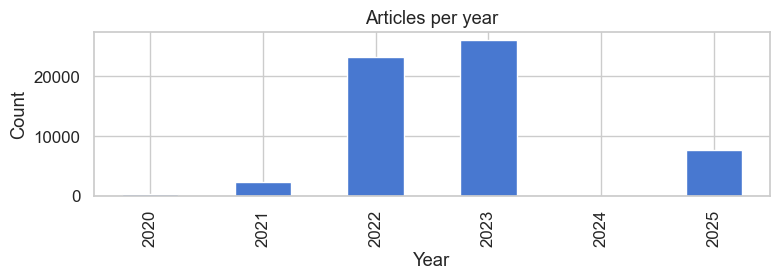

In [7]:
df["date"] = pd.to_datetime(df["date"])
print(df["date"].agg(["min", "max"]))

# Extract year directly instead of using resample
articles_by_year = df["date"].dt.year.value_counts().sort_index()

# Plot
articles_by_year.plot(kind="bar", figsize=(8, 3), title="Articles per year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.tight_layout()


### 1.3 Article length distribution


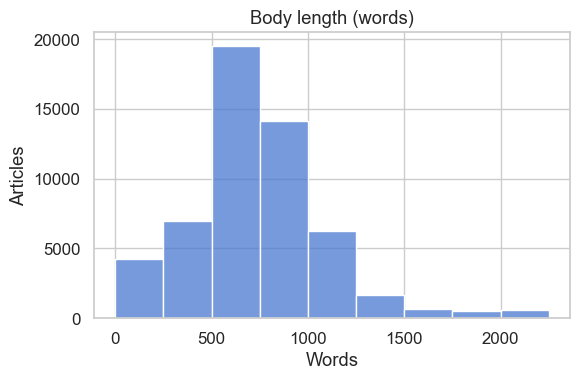

In [9]:
df["body_words"] = df["content"].str.split().str.len()
bins = np.arange(0, 2500, 250)

plt.figure(figsize=(6,4))
sns.histplot(df["body_words"], bins=bins, kde=False)
plt.title("Body length (words)")
plt.xlabel("Words"); plt.ylabel("Articles")
plt.tight_layout()


In [22]:
median_words = df["body_words"].median()
max_words = df["body_words"].max()

print(f"Length: median {int(median_words)} words; long tail up to {int(max_words)} words.")

Length: median 740 words; long tail up to 9545 words.


## 2  Ticker analysis
We don’t yet have the full NER module, so we’ll use a **regex prototype**  
`[A-Z]{1,5}` and whitelist against `master_ticker_list.csv`.


Articles with ≥2 ticker: 85.50%


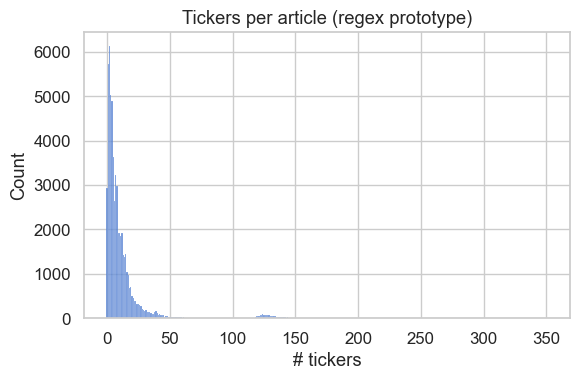

In [15]:
TICKER_CSV = Path("../data/master_ticker_list.csv")
tickers = set(pd.read_csv(TICKER_CSV)["symbol"].values)

ticker_regex = re.compile(r"\b[A-Z]{1,5}\b")

def extract(line: str) -> list[str]:
    return [m.group() for m in ticker_regex.finditer(line) if m.group() in tickers]

df["tickers"] = (df["title"] + " " + df["content"]).apply(extract)
df["ticker_count"] = df["tickers"].str.len()

print(f"Articles with ≥2 ticker: {(df['ticker_count']>1).mean()*100:.2f}%")

plt.figure(figsize=(6,4))
sns.histplot(df["ticker_count"], discrete=True, bins=range(1,12))
plt.title("Tickers per article (regex prototype)")
plt.xlabel("# tickers")
plt.tight_layout()


### 2.1 Top-20 tickers


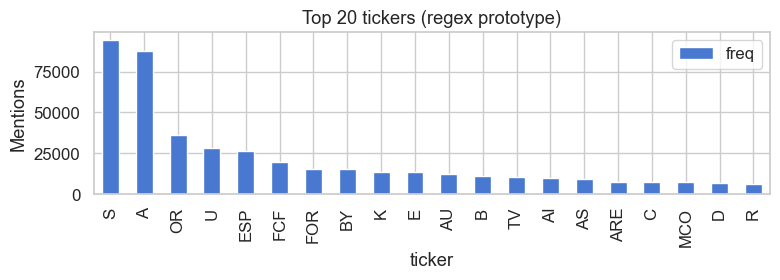

In [20]:
from collections import Counter
top20 = Counter(t for ts in df["tickers"] for t in ts).most_common(20)
pd.DataFrame(top20, columns=["ticker","freq"]).set_index("ticker").plot.bar(figsize=(8,3))
plt.title("Top 20 tickers (regex prototype)"); plt.ylabel("Mentions")
plt.tight_layout()


## 3  Lexicon baseline sentiment — VADER


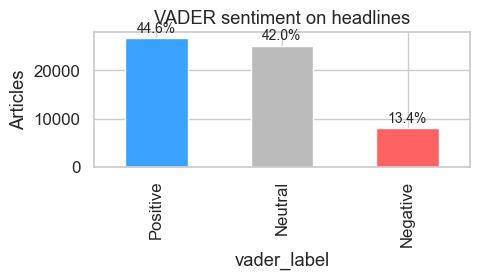

In [23]:
vader = SentimentIntensityAnalyzer()

def vader_label(text):
    score = vader.polarity_scores(text)["compound"]
    if score >=  0.05: return "Positive"
    if score <= -0.05: return "Negative"
    return "Neutral"

# Count and sort labels
sent_counts = df["vader_label"].value_counts().reindex(["Positive", "Neutral", "Negative"])
total = sent_counts.sum()
percentages = (sent_counts / total * 100).round(1)

# Plot bar chart
ax = sent_counts.plot.bar(color=["#3BA1FF", "#BBBBBB", "#FF6262"], figsize=(5, 3))
plt.title("VADER sentiment on headlines")
plt.ylabel("Articles")

# Annotate percentages
for i, (count, pct) in enumerate(zip(sent_counts, percentages)):
    ax.text(i, count + total * 0.01, f"{pct}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()


### 3.1 Quick sanity sample  
Random 3 headlines per class.


In [19]:
for label in ["Positive","Neutral","Negative"]:
    sample = df[df["vader_label"]==label]["title"].sample(3, random_state=42).tolist()
    print(f"\n{label} examples:")
    print(textwrap.indent("\n".join(sample), "  • "))



Positive examples:
  • Are Hochschild Mining plc (LON:HOC) Investors Paying Above The Intrinsic Value?
  • Calculating The Fair Value Of e.l.f. Beauty, Inc. (NYSE:ELF)
  • A Look At The Intrinsic Value Of Tyro Payments Limited (ASX:TYR)

Neutral examples:
  • Viasat Releases Fourth Quarter and Fiscal Year 2025 Financial Results
  • Aecom Technology (ACM) Earnings Expected to Grow: What to Know Ahead of Next Week's Release
  • 4 High Earnings Yield Value Picks Amid Prevailing Uncertainty

Negative examples:
  • FINAL DEADLINE FOR FUTU HOLDINGS LIMITED INVESTORS: Kessler Topaz Meltzer &amp; Check, LLP Reminds Futu Holdings Limited (NASDAQ: FUTU) Investors of August 11, 2023 Lead Plaintiff Deadline
  • One Estia Health Limited (ASX:EHE) insider upped their stake by 36% in the previous year
  • Citigroup (C) Q4 Earnings Lag Estimates


## 4  Findings (proposal stage)

* **Volume:** 60 k English finance-tagged articles, Jan 2020 → May 2025.  
* **Length:** median 740 words; long tail up to 9545 words.  
* **Tickers:** ~85 % of articles mention ≥2 ticker (regex prototype).  
  * Median 2 tickers; top tickers are S, A.  
* **Baseline sentiment (VADER on headlines):** Neutral ~46 %, Positive ~42 %, Negative ~13 %.  
  → motivates a transformer model to capture context & reduce bias.

These insights support our proposal to build a FinBERT-based pipeline with
hybrid NER and aggregation at ticker & sector level.


### 5  Next steps (as per original proposal)

1. Implement robust Ticker NER (spaCy + regex + whitelist).  
2. Apply FinBERT chunk-level sentiment; compare to VADER baseline.  
3. Build gold-standard sample for evaluation and error analysis.

*(These tasks are now completed in later project stages.)*
